# Introduction


**ASSIGNMENT DEADLINE: 28 March 2021 23:59**

In this assignemnt, the task is to implement some basic components for training recurrent neural network (RNN) over the NLTK dataset. You need to follow the lecture notes to 
- implement gru operations in nn/operators.py;
- implement the forward function of Bi-directional RNN (in nn/layer.py);
- tune the model architecture and some hyperparameters to improve your best SentimentNet.

**Attention**:
- To run this Jupyter notebook, you need to install the dependent libraries as stated in [README.MD](README.MD). You do not need and should not use other libraries (like tensorflow and pytorch) in your code. The major version of Python should be 3.
- You do not need a GPU for this assignment. CPU is enough.
- Before you finish the implementation of the required functions, if you run this notebook, you may see errors.
- Do not change the signature (the name and arguments) of the existing functions in the repository ; otherwise your implementation cannot be tested correctly and you will get penalty.
- Do not change the structure of files in the repository (e.g., adding, renaming or deleting any files); otherwise your implementation cannot be tested correctly and you will get penalty.
- You can add functions in the existing files, but you should not change the import statements (e.g., adding a new import statement). For example, if you want to implement a function foo(), you can implement it inside operator.py and call it; but you cannot implement it in another file and import that file in operators.py. Otherwise your implementation cannot be tested correctly and you will get penalty.
- After you implement one function, remember to restart the notebook kernel to help it recognize your fresh code.

**If you have any problem about the assignment, please email yuziwei@u.nus.edu.**

In [2]:
import tensorflow as tf 
print(tf.__version__)

1.14.0


In [3]:
import keras 
print(keras.__version__)

2.3.1


## Structure of the repository

The structure of this repository is shown as below:

```bash
codes/
    data/
        datasets.py     # load dataset
        corpus.csv      # for nltk dataset 
        dictionary.csv  # for nltk dataset
    models/             # example models of your tiny deep learning framework
        SentimentNet.py # example model on nltk dataset
    nn/                 # components of neural networks
        operators.py    # operators; **You need to edit this file to add missing code**
        optimizers.py   # optimizing methods;
        layers.py       # layer abstract for RNN
        loss.py         # loss function for optimization
        model.py        # model abstraction for defining and training models
        initializers.py # initializing methods to initialize parameters (like weights, bias)
        funtional.py    # some helpful function during implementation of training
    utils/              # some additional tools for RNN
        check_grads_rnn.py  # for RNN, help you check your forward function and backward function
        tools.py        # other useful functions for testing the codes
    main.ipynb          # this notebook which calls the functions in other modules/files
    README.MD           # list of dependent libraries
```

## Functionality of this notebook

This iPython notebook serves to:

- explain code structure, main APIs
- explain your implementation task and tuning task
- provide code to test your implemented forward and backward function for different operations
- provide related materials to help you understand the implementation of some operations and optimizers

*You can type `jupyter lab` in the terminal to start this jupyter notebook when your current working directory is cs5242. It's much more convinient than jupyter notebook.*

# Your tasks for RNN

## GRU layer


The GRU layer calls the forward and backward functions of the gru operator in [nn/operators.py](nn/operators.py) to do the real operation.

You need to implement the forward and backward function of the `gru` operator

```python
class GRU(Layer):
    def __init__(self, in_features, units, h0=None, name='gru', initializer=Gaussian()):
        """
        # Arguments
            in_features: int, the number of input features
            units: int, the number of hidden units
            h0: default initial state, numpy array with shape (units,)
        """
        super(GRU, self).__init__(name=name)
        self.trainable = True
        self.cell = gru()  # it's operation instead of layer

        self.kernel = initializer.initialize((in_features, 3 * units))
        self.recurrent_kernel = initializer.initialize((units, 3 * units))

        if h0 is None:
            self.h0 = np.zeros(units)
        else:
            self.h0 = h0

        self.kernel_grad = np.zeros(self.kernel.shape)
        self.r_kernel_grad = np.zeros(self.recurrent_kernel.shape)
```


### Forward function of gru operator

In the file [nn/operators.py](nn/operators.py), implement the forward function for `gru` operation. (`input` is a list of two numpy arrays, `[x, h]`). 

The following cell test the implementation.

In [4]:
import numpy as np
import keras
from keras import layers
from nn.layers import GRUCell
from utils.tools import rel_error

N, D, H = 3, 10, 4
x = np.random.uniform(size=(N, D))
prev_h = np.random.uniform(size=(N, H))

gru_cell = GRUCell(in_features=D, units=H)
out = gru_cell.forward([x, prev_h])
# compare with the keras implementation
keras_x = layers.Input(shape=(1, D), name='x')
keras_prev_h = layers.Input(shape=(H,), name='prev_h')
keras_rnn = layers.GRU(units=H, use_bias=False, recurrent_activation='sigmoid')(keras_x, initial_state=keras_prev_h)
keras_model = keras.Model(inputs=[keras_x, keras_prev_h], 
                          outputs=keras_rnn)
keras_model.layers[2].set_weights([gru_cell.kernel,
                                   gru_cell.recurrent_kernel])
keras_out = keras_model.predict_on_batch([x[:, None, :], prev_h])

print('Relative error (<1e-5 will be fine): {}'.format(rel_error(keras_out, out)))

Relative error (<1e-5 will be fine): 4.154421120080381e-08


### Backward function of gru operator

Implement the backward function for the `gru` operation in the file [nn/operators.py](nn/operators.py). 

When you are done, restart jupyter notebook and run the following cell to check your implementation

In [5]:
import numpy as np
from nn.layers import GRUCell
from utils.check_grads_rnn import check_grads_layer

N, D, H = 3, 10, 4
x = np.random.uniform(size=(N, D))
prev_h = np.random.uniform(size=(N, H))
in_grads = np.random.uniform(size=(N, H))

gru_cell = GRUCell(in_features=D, units=H)

check_grads_layer(gru_cell, [x, prev_h], in_grads)

Gradient to input 0: correct
Gradient to input 1: correct
Gradient to -:gru_cell/kernel: correct
Gradient to -:gru_cell/recurrent_kernel: correct


## BiRNN layer

Vallina RNN operates over input sequence in one direction, so it has limitations as the future input information cannot be reached from the current state. On the contrary, Bi-directional RNN addresses this shortcoming by operating the input sequence in both forward and backward directions. 

Usually, Bi-directional RNN is implemented by running two independent RNNs in opposite direction of the input data, and concatenating the outputs of the two RNNs. The following function reverses a batch of sequence data  which is necessary for implementing Bi-directional RNN.

```python
def _reverse_temporal_data(self, x, mask):
    num_nan = np.sum(~mask, axis=1)
    reversed_x = np.array(x[:, ::-1, :])
    for i in range(num_nan.size):
        reversed_x[i] = np.roll(reversed_x[i], x.shape[1]-num_nan[i], axis=0)
    return reversed_x
```

### Forward function of BiRNN layer

Please implement `BiRNN.forward(self, inputs)` [nn/layers.py](nn/layers.py) and use the following code for testing. Note that `H` is the dimension of the hidden states of one internal RNN, so the actual dimension of the hidden states (or outputs) of Bidirectional RNN is `2*H`.

In [7]:
import numpy as np
import keras
from keras import layers
from nn.layers import BiRNN
from utils.tools import rel_error

N, T, D, H = 2, 3, 4, 5
x = np.random.uniform(size=(N, T, D))
x[0, -1:, :] = np.nan
x[1, -2:, :] = np.nan
h0 = np.random.uniform(size=(H,))
hr = np.random.uniform(size=(H,))

brnn = BiRNN(in_features=D, units=H, h0=h0, hr=hr)
out = brnn.forward(x)

keras_x = layers.Input(shape=(T, D), name='x')
keras_h0 = layers.Input(shape=(H,), name='h0')
keras_hr = layers.Input(shape=(H,), name='hr')
keras_x_masked = layers.Masking(mask_value=0.)(keras_x)
keras_rnn = layers.RNN(layers.SimpleRNNCell(H), return_sequences=True)
keras_brnn = layers.Bidirectional(keras_rnn, merge_mode='concat', name='brnn')(
        keras_x_masked, initial_state=[keras_h0, keras_hr])
keras_model = keras.Model(inputs=[keras_x, keras_h0, keras_hr],
                          outputs=keras_brnn)
keras_model.get_layer('brnn').set_weights([brnn.forward_rnn.kernel,
                                           brnn.forward_rnn.recurrent_kernel, 
                                           brnn.forward_rnn.bias,
                                           brnn.backward_rnn.kernel, 
                                           brnn.backward_rnn.recurrent_kernel,
                                           brnn.backward_rnn.bias])
keras_out = keras_model.predict_on_batch([np.nan_to_num(x), np.tile(h0, (N, 1)), np.tile(hr, (N, 1))])
nan_indices = np.where(np.any(np.isnan(x), axis=2))
keras_out[nan_indices[0], nan_indices[1], :] = np.nan

print('Relative error (<1e-5 will be fine): {}'.format(rel_error(keras_out, out)))

Relative error (<1e-5 will be fine): 9.283527829580265e-08


## Sentiment analysis using RNNs

In this section, you need to implement a RNN model for sentiment analysis. The dataset, `data/corpus.csv`, consists of 800 real movie comments and the corresponding labels that indicate whether the comments are positive or negative. For example:
```
POSTIVE: I absolutely LOVE Harry Potter, as you can tell already.
NEGATIVE: My dad's being stupid about brokeback mountain...
```

We provide a basic model for your experiments, which can be found in [models/SentimentNet.py](models/SentimentNet.py). The architecture is as follow:

```python
Linear(vocab_size, 200, name='embedding')
BiRNN(in_features=200, units=50, initializer=Gaussian(std=0.01))
Linear(100, 32, name='linear1')
TemporalPooling()
Linear(32, 2, name='linear2')
```

The input to the network is a sequence of one-hot vectors, each of which represents a word. The 1st Linear layer works as an embedding layer. After a Bi-directional RNN layer and another Linear layer, a TemporalPooling layer (see `layers.py`) is used to aggregate the vectors into one vector, which skips `NaN`s. The rest of the network is the same as a normal classifier.

In [2]:
from data import datasets
from models.SentimentNet import SentimentNet
from nn.loss import SoftmaxCrossEntropy, L2
from nn.optimizers import Adam
import numpy as np
np.random.seed(5242)

dataset = datasets.Sentiment()
model = SentimentNet(dataset.dictionary)
loss = SoftmaxCrossEntropy(num_class=2)

adam = Adam(lr=0.01, decay=0,
            sheduler_func=lambda lr, it: lr*0.5 if it%1000==0 else lr)
model.compile(optimizer=adam, loss=loss, regularization=L2(w=0.001))
train_results, val_results, test_results = model.train(
        dataset, 
        train_batch=20, val_batch=100, test_batch=100, 
        epochs=5, 
        val_intervals=-1, test_intervals=25, print_intervals=5)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/aoxiangsuen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Number of training samples: 600
Number of validation samples: 100
Number of testing samples: 100
Epoch 0: 
Train iter 5/30:	acc 0.45, loss 0.72, reg loss 0.01, speed 90.01 samples/sec
Train iter 10/30:	acc 0.45, loss 0.73, reg loss 0.00, speed 109.41 samples/sec
Train iter 15/30:	acc 0.65, loss 0.65, reg loss 0.00, speed 109.91 samples/sec
Train iter 20/30:	acc 0.55, loss 0.70, reg loss 0.00, speed 101.99 samples/sec
Test acc 0.60, loss 0.67
Train iter 25/30:	acc 0.60, loss 0.67, reg loss 0.00, speed 54.09 samples/sec
Epoch 1: 
Train iter 5/30:	acc 0.65, loss 0.68, reg loss 0.00, speed 82.78 samples/sec
Train iter 10/30:	acc 0.55, loss 0.69, reg loss 0.00, speed 94.87 samples/sec
Train iter 15/30:	acc 0.70, loss 0.62, reg loss 0.00, speed 87.74 samples/sec
Train iter 20/30:	acc 0.65, loss 0.67, reg loss 0.00, speed 90.70 samples/sec
Test acc 0.65, loss 0.68
Train iter 25/30:	acc 0.65, loss 0.68, reg loss 0.00, speed 52.84 samples/sec
Epoch 2: 
Train iter 5/30:	acc 0.75, loss 0.53, reg 

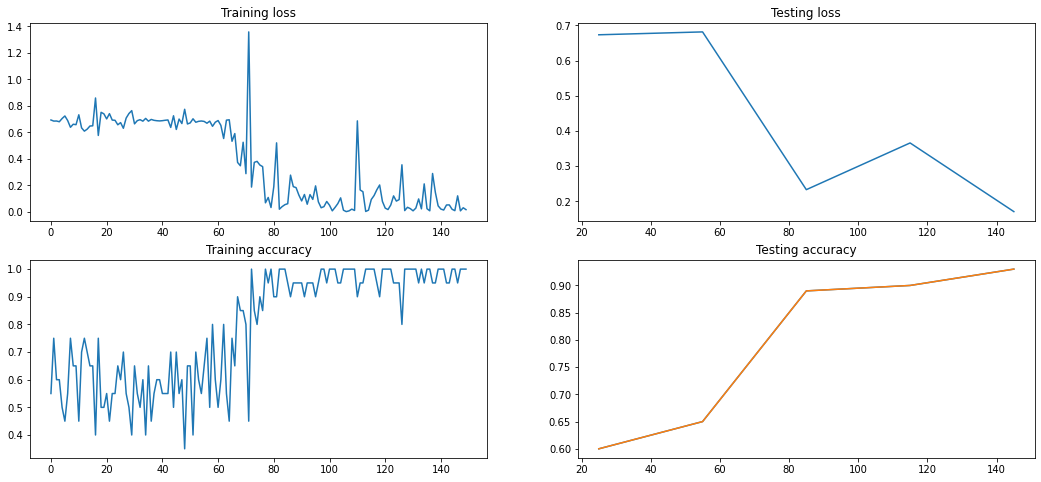

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(18, 8))
plt.subplot(2, 2, 1)
plt.title('Training loss')
plt.plot(train_results[:,0], train_results[:,1])
plt.subplot(2, 2, 3)
plt.title('Training accuracy')
plt.plot(train_results[:,0], train_results[:,2])
plt.subplot(2, 2, 2)
plt.title('Testing loss')
plt.plot(test_results[:,0], test_results[:, 1])
plt.subplot(2, 2, 4)
plt.title('Testing accuracy')
plt.plot(test_results[:, 0], test_results[:,2])
plt.plot(test_results[:, 0], test_results[:,2])

### Train your best SentimentNet!

Tweak the hyperparameters and structure of the SentimentNet.

The following cell should include your model e.g., `class MyModel` (similar to SentimentNet), the training and validation code. You just need to include the model with the best performance. When you submit, the execution results (output of the cell) should be kept. (if you can improve it to 97%, you can get full marks)

Noted:

1. You can write your model in the Jupyter notebook or in a separate python file
2. You can follow my test part (above) to test and show your implemented model performance. 
3. You can add layers or tune the parameters or some other way(network structure) to improve your model's accuracy

In [84]:
# define your new model and all training codes here, like loading data, defining optimizer and so on

# ...

from nn.layers import *
from nn.model import Model
from nn.initializers import *

def MyModel(word_to_idx):
    """Construct a RNN model for sentiment analysis

    # Arguments:
        word_to_idx: A dictionary giving the vocabulary. It contains V entries,
            and maps each string to a unique integer in the range [0, V).
    # Returns
        model: the constructed model
    """
    vocab_size = len(word_to_idx)

    model = Model()
    model.add(Linear2D(vocab_size, 200, name='embedding', initializer=Gaussian(std=0.01)))
    model.add(BiRNN(in_features=200, units=50, initializer=Gaussian(std=0.01)))
    model.add(Linear2D(100, 32, name='linear1', initializer=Gaussian(std=0.01)))
    model.add(TemporalPooling()) # defined in layers.py
    model.add(Linear2D(32, 2, name='linear2', initializer=Gaussian(std=0.01)))
    
    return model

In [85]:
from data import datasets
from nn.loss import SoftmaxCrossEntropy, L2
from nn.optimizers import Adam
import numpy as np
np.random.seed(5242)

dataset = datasets.Sentiment()
model = MyModel(dataset.dictionary)
loss = SoftmaxCrossEntropy(num_class=2)

adam = Adam(lr=0.001, decay=0,
            sheduler_func=lambda lr, it: lr*0.5 if it%1000==0 else lr)
model.compile(optimizer=adam, loss=loss, regularization=L2(w=0.001))
train_results, val_results, test_results = model.train(
        dataset, 
        train_batch=20, val_batch=100, test_batch=100, 
        epochs=30, 
        val_intervals=-1, test_intervals=25, print_intervals=5)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/aoxiangsuen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Number of training samples: 600
Number of validation samples: 100
Number of testing samples: 100
Epoch 0: 
Train iter 5/30:	acc 0.45, loss 0.69, reg loss 0.01, speed 59.13 samples/sec
Train iter 10/30:	acc 0.45, loss 0.70, reg loss 0.01, speed 78.68 samples/sec
Train iter 15/30:	acc 0.65, loss 0.68, reg loss 0.01, speed 76.01 samples/sec
Train iter 20/30:	acc 0.55, loss 0.69, reg loss 0.01, speed 75.75 samples/sec
Test acc 0.60, loss 0.68
Train iter 25/30:	acc 0.60, loss 0.68, reg loss 0.01, speed 42.73 samples/sec
Epoch 1: 
Train iter 5/30:	acc 0.65, loss 0.66, reg loss 0.01, speed 65.77 samples/sec
Train iter 10/30:	acc 0.55, loss 0.69, reg loss 0.01, speed 77.31 samples/sec
Train iter 15/30:	acc 0.70, loss 0.65, reg loss 0.01, speed 76.49 samples/sec
Train iter 20/30:	acc 0.65, loss 0.66, reg loss 0.01, speed 77.15 samples/sec
Test acc 0.60, loss 0.68
Train iter 25/30:	acc 0.60, loss 0.68, reg loss 0.00, speed 46.37 samples/sec
Epoch 2: 
Train iter 5/30:	acc 0.60, loss 0.67, reg los

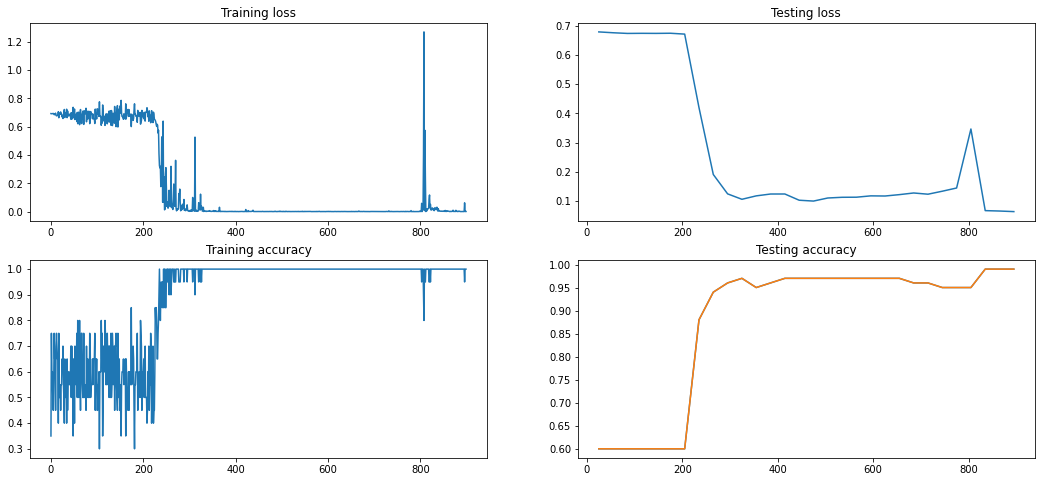

In [86]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(18, 8))
plt.subplot(2, 2, 1)
plt.title('Training loss')
plt.plot(train_results[:,0], train_results[:,1])
plt.subplot(2, 2, 3)
plt.title('Training accuracy')
plt.plot(train_results[:,0], train_results[:,2])
plt.subplot(2, 2, 2)
plt.title('Testing loss')
plt.plot(test_results[:,0], test_results[:, 1])
plt.subplot(2, 2, 4)
plt.title('Testing accuracy')
plt.plot(test_results[:, 0], test_results[:,2])
plt.plot(test_results[:, 0], test_results[:,2])

# Marking Scheme

Marking scheme is shown below:
- 3 marks for `gru` forward and backward function
- 3 marks for `BiRNN` forward function
- 3 marks for tuning your best SentimentNet
- 1 marks for your submission format

We will run multiple test cases to check the correctness of your implementation. You may not get the full marks even if you pass the tests in this notebook as we have a few other test cases for each task, which are not included in this notebook.

For the tuning tasks, please use a fixed random seed (e.g., 0) to make sure the results are reproducible. 

As for submission format, please follow below submission instructions.

**DO NOT** use external libraries like Tensorflow, keras and Pytorch in your implementation. **DO NOT** copy the code from the internet, e.g. github. We have offered all materials that you can refer to in this notebook.

# Final submission instructions
Please submit the following:

1) Your codes in a folder named `codes`, and keep the structure of all files in this folder the same as what we have provided. 

**ASSIGNMENT DEADLINE: 28 March 2021 23:59**

Do not include the `data` folder. Please zip the following folders under a folder named with your STUDENT ID: eg. `a0123456g.zip` and submit the zipped folder to LumiNUS/Files/Assignment Submission. If we unzip the file, the structure should be like this:

```bash
a0123456g/
    codes/
        models/
            ...
        nn/
            ...
        utils/
            ...
        main.ipynb
        README.MD
```